<a href="https://colab.research.google.com/github/Samuel-CHLam/activation_sparsity/blob/master/Deep_Learning_Simulation_WeekF06_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from keras.utils.generic_utils import get_custom_objects
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.integrate
import warnings
from scipy.stats import norm, multivariate_normal
from tqdm import tqdm

# Week Michaelmas 06 - Exploring the length and correlation map
In this week, we would like to explore the length and correlation maps for deep neural network with soft thresholding activation. Recall that a soft-thresholding activation with parameter $\tau > 0$ takes the form
$$\phi(z) = \phi^{\mathsf{soft}}_\tau(z) = \mathsf{sgn}(z) (z-\tau)_+ = (z-\tau)_{+} - (-z-\tau)_{+},$$
where $z_+ = \max(z,0)$.

In [ ]:
# You may wish to set the default tau here.
tau = 1

In [ ]:
def soft_thresholding(x, tau=tau):
  return K.relu(x - tau) - K.relu(-x - tau)

def soft_thresholding_numpy(x, tau=tau):
  return np.maximum(x-tau, 0) - np.maximum(-x-tau, 0)

get_custom_objects().update({'custom_activation': Activation(soft_thresholding)})

# Part 1. Observing the length map
The length map is given by
$$V_\phi(q) = \sigma^2_w \int_\mathbb{R} (\phi(\sqrt{q} z))^2 \gamma(dz) + \sigma^2_b.$$

There are three ways to observe the length map, and compute the equilibrium points:
- By numerically compute the integral
- By analytically compute the integral (in terms of the CDF of a normal density).
- By iterating over a neural network.

**Task.** Let us build a function which compute the length map numerically.

In [ ]:
# Numerical computation
def normal(z):
  return (1/np.sqrt(2*np.pi))*np.exp(-(z**2)/2)

def integrand(z,q,tau=tau):
  return normal(z)*(soft_thresholding_numpy(np.sqrt(q)*z, tau=tau)**2)

def length_map_numerical(q,sw,sb,tau=tau):
  inter_q, _ = sp.integrate.quad(lambda z: integrand(z, q, tau=tau), -np.inf, np.inf)
  return (sw**2)*inter_q + sb**2

**Task.** Let us build a function which compute the length map using the CDF of a standard normal. The formula is given by 
$$
\begin{aligned}
V_\phi(q) 
&= 2\sigma^2_w \Bigg[(q+\tau^2) \tilde{\Phi}\bigg( \frac{\tau}{\sqrt{q}} \bigg) - \sqrt{q}\tau \phi \bigg(\frac{\tau}{\sqrt{q}} \bigg) \Bigg] + \sigma^2_b
\end{aligned}$$
where $\phi$ is the normal density, $\Phi(z)$ (called as `norm.cdf`) being the standard normal CDF and and $\tilde{\Phi}(z) = 1 - \Phi(z)$ (called as `norm.sf`).

In [ ]:
# Analytical computation
def length_map_analytical(q,sw,sb,tau=tau):
  ratio = tau/np.sqrt(q)
  inter_q = (q + tau**2) * norm.sf(ratio) - np.sqrt(q) * tau * normal(ratio)
  return 2*(sw**2) * inter_q + sb**2

**Task:** Let's make sure the two functions are consistent with each other. Here we choose $\sigma_w = 1$ and $\sigma_b = .3$.

[0.11313578589953746, 0.16270091806606807, 0.2360509698422781, 0.3284485799465415, 0.4362613854017755, 0.5567948095883573, 0.6880241181178467, 0.828395292793525, 0.9766899726662611, 1.1319343337700762, 1.2933366139363598, 1.4602433782731143, 1.6321082345472109, 1.808468993219086, 1.9889306792240702, 2.1731526775390875, 2.3608388568256715, 2.5517298757651314, 2.745597108801586, 2.9422378015836315, 3.1414711634688177, 3.34313517959792, 3.5470839994351815, 3.753185769921593, 3.961320827562876, 4.171380179261161, 4.383264221029877, 4.596881639931289, 4.812148486244883, 5.02898736513429, 5.247326744810132, 5.46710035136534, 5.688246647418108, 5.910708368329051, 6.134432120262438, 6.35936802317535, 6.585469396750797, 6.812692478323388, 7.040996176174231, 7.270341836530572, 7.500693081528145, 7.732015560617292, 7.964276938128564, 8.197446390118747, 8.431495058165961, 8.66639534137142, 8.902121170621733, 9.138647732922282, 9.375951449965566, 9.614009870202192, 9.852801609434676, 10.09230627032

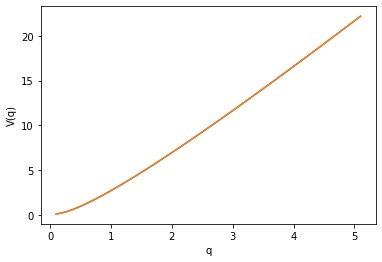

In [ ]:
tau, sw, sb = 0.5, 1., 0.3
x_eval = np.linspace(0.1,5.1,100)
y_numerical = [length_map_numerical(q, sw=2.5, sb=0.3, tau=tau) for q in np.linspace(0.1,5.1,100)]
y_analytical = length_map_analytical(x_eval, sw=2.5, sb=0.3, tau=tau)
plt.plot(x_eval, y_numerical)
plt.plot(x_eval, y_analytical)
plt.xlabel("q")
plt.ylabel("V(q)")

print([length_map_numerical(q, sw=2.5, sb=0.3, tau=tau) for q in np.linspace(0.1,5.1,100)])
print([length_map_analytical(q, sw=2.5, sb=0.3, tau=tau) for q in np.linspace(0.1,5.1,100)])

**Task:** Let's try simulate various iterations of the length map.

In [ ]:
def compute_q_star(sw,sb,tau=tau,N=1000,mode="analytical",seed=None,max_steps=50,show_hist=False,clip=50,err_val=-5):
  x = np.random.normal(size=N)

  # use initial condition given in the paper
  q0 = (1/len(x))*np.dot(x,x)
  q1 = (sw**2)*q0 + sb**2 

  # storing the iterates
  qs = []
  qs.append(q0)
  qs.append(q1)

  #iterate to convergence within specified tolerance
  count = 0
  while (np.abs(qs[count+1]-qs[count]) > 1e-04).any() and count <= max_steps:
    if mode == "analytical":
      q1 = length_map_analytical(q1, sw=sw, sb=sb, tau=tau)

    if mode == "numerical":
      # only support scalar output
      q1 = length_map_numerical(q1, sw=sw, sb=sb, tau=tau)

    qs.append(q1)
    count+=1

  if show_hist:
    # only support scalar output
    plt.plot(qs)
    plt.xlabel('$\ell$')
    plt.ylabel('$q^\ell$')
    print(np.array(qs))

  q_final = qs[-1]
  print(type(q_final))

  if type(q_final) == np.ndarray:
    q_final[q_final > clip] = err_val
    # q_final[q_final < -0.1] = err_val
    return q_final
  else:
    if q_final > clip:
      return err_val
    else:
      return q_final

Note that the length map does not necessary converge, and even if it converges, it might not necessary converge to a positive values.

[1.02286938 1.11286938 0.57999417 0.26960584 0.13407233 0.09859334
 0.09354337 0.09300452 0.09294978]
<class 'numpy.float64'>


0.09294977577044558

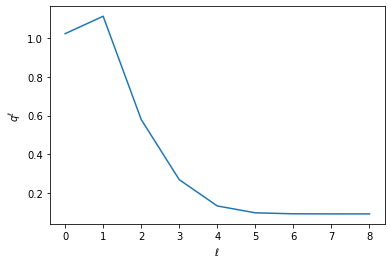

In [ ]:
compute_q_star(1,.3,show_hist=True)

[1.04139804 2.04139804 2.12827344 2.19161558 2.23808912 2.27233509
 2.29764875 2.31640152 2.33031633 2.3406535  2.34833954 2.35405803
 2.35831467 2.36148427 2.36384504 2.36560373 2.36691407 2.36789048
 2.3686181  2.36916037 2.36956451 2.36986572 2.37009022 2.37025755
 2.37038227 2.37047524]
<class 'numpy.float64'>


2.370475235795862

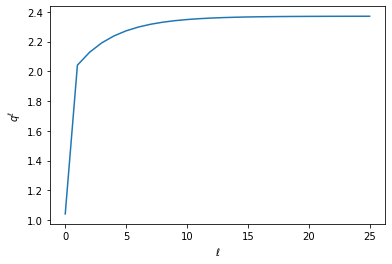

In [ ]:
compute_q_star(1,1,show_hist=True)

[9.72762440e-01 1.00972762e+02 1.93201895e+02 2.82359141e+02
 3.69199873e+02 4.54117130e+02 5.37362631e+02 6.19115368e+02
 6.99511045e+02 7.78657121e+02 8.56641417e+02 9.33537447e+02
 1.00940792e+03 1.08430714e+03 1.15828273e+03 1.23137691e+03
 1.30362741e+03 1.37506824e+03 1.44573026e+03 1.51564161e+03
 1.58482812e+03 1.65331358e+03 1.72112001e+03 1.78826787e+03
 1.85477621e+03 1.92066285e+03 1.98594451e+03 2.05063688e+03
 2.11475478e+03 2.17831217e+03 2.24132227e+03 2.30379764e+03
 2.36575017e+03 2.42719119e+03 2.48813151e+03 2.54858143e+03
 2.60855078e+03 2.66804900e+03 2.72708510e+03 2.78566773e+03
 2.84380521e+03 2.90150553e+03 2.95877636e+03 3.01562511e+03
 3.07205891e+03 3.12808463e+03 3.18370892e+03 3.23893821e+03
 3.29377868e+03 3.34823635e+03 3.40231702e+03 3.45602634e+03
 3.50936975e+03]
<class 'numpy.float64'>


-5

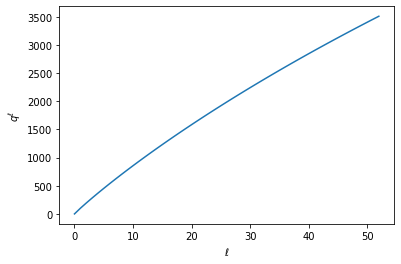

In [ ]:
compute_q_star(1,10,show_hist=True)

**Task:** Let's compute the fixed points for different values of $\sigma_w$ and $\sigma_b$.

In [ ]:
nx, ny = (300,300)
x = np.linspace(.1, 1.5, nx)
y = np.linspace(.1, 1.5, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
zss = compute_q_star(xv, yv, tau=0.5, max_steps=100, clip=20, err_val=-10)

# zs = np.zeros(xv.shape)
# for i in tqdm(range(nx)):
#  for j in range(ny):
#    zs[i,j] = compute_q_star(xv[i,j], yv[i,j], tau=0.5, max_steps=6, clip=5)

<class 'numpy.ndarray'>


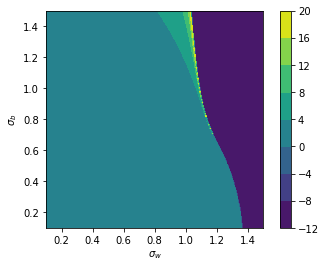

In [ ]:
h = plt.contourf(x, y, zss)
plt.axis('scaled')
plt.xlabel("$\sigma_w$")
plt.ylabel("$\sigma_b$")
plt.colorbar()
plt.show()

# Part 2. Compute the edge of chaos curve.

The edge of chaos have the following formula for soft-thresholding.
$$\chi_1 = \sigma^2_w \int_\mathbb{R} \left(\phi'(\sqrt{q^*} z) \right)^2 \, \gamma(dz) = 2\sigma^2_w \tilde{\Phi}\left(\frac{\tau}{\sqrt{q^*}}\right) = 1$$

We may therefore simulate the edge of chaos by fixing $q^*$, then find $\sigma_w$ then $\sigma_b$. Again, we may compute this edge of chaos curve numerically (using Scipy integrator) or using `norm.sf`.

We note that $V'_\phi(q) = 2\sigma^2_w \tilde{\Phi}\left(\frac{\tau}{\sqrt{q}} \right)$ as well.

**Task:** Implement a function which takes in $q^*$ and compute the theoretical $\sigma_w$ and $\sigma_b$.

In [ ]:
def get_sw_sb_from_q_star_numerical(qstar, tau=tau, check=False, min_qstar=None, max_qstar=None):
  def d_soft(z,tau=tau):
    return 1 - (np.abs(z) < tau)

  def chi_1_integrand(z, qstar, tau=tau):
    return normal(z)*(d_soft(np.sqrt(qstar)*z, tau=tau))**2
    
  def calc_sw(qstar, tau=tau):
    integral, _ = sp.integrate.quad(lambda z: chi_1_integrand(z,qstar,tau=tau), -np.inf, np.inf)
    return np.sqrt(np.divide(1,integral))

  def calc_sb(qstar, sw, tau=tau):
    integral, _ = sp.integrate.quad(lambda z: integrand(z,qstar,tau=tau), -np.inf, np.inf)
    return np.sqrt(qstar - (sw**2)*integral)
  
  c_sw = calc_sw(qstar)
  c_sb = calc_sb(qstar, c_sw)

  if check:
    if max_qstar == None:
      max_qstar = 2
    qstar_eval = np.linspace(0, max_qstar, 500)
    plt.plot(qstar_eval, length_map_analytical(qstar_eval, c_sw, c_sb), label="length map")
    plt.plot(qstar_eval, qstar_eval, label="identity")
    plt.xlabel("q[l]")
    plt.ylabel("q[l+1]")
    plt.legend()
    print(float(length_map_analytical(qstar, c_sw, c_sb)), float(compute_q_star(c_sw, c_sb)))
  return (c_sw, c_sb)

In [ ]:
def get_sw_sb_from_q_star_analytical(q, tau=tau, check=False, min_qstar=None, max_qstar=None):
  ratio = tau/np.sqrt(q)
  sw2 = 0.5/norm.sf(ratio)
  sb2 = q - 2*sw2*((q + tau**2) * norm.sf(ratio) - np.sqrt(q) * tau * normal(ratio))
  output = np.sqrt(np.array([sw2, sb2]))

  if check:
    if max_qstar == None:
      max_qstar = 2
    qstar_eval = np.linspace(0, max_qstar, 500)
    plt.plot(qstar_eval, length_map_analytical(qstar_eval, output[0], output[1]), label="length map")
    plt.plot(qstar_eval, qstar_eval, label="identity")
    plt.xlabel("q[l]")
    plt.ylabel("q[l+1]")
    plt.legend()
    print(float(length_map_analytical(q, output[0], output[1])), float(compute_q_star(output[0], output[1])))
  return output

In [ ]:
qstar_eval = np.logspace(0, 1.53, 100)

sigma_ws_numerical = []
sigma_bs_numerical = []

for qstar in tqdm(qstar_eval):
  sw, sb = get_sw_sb_from_q_star_numerical(qstar, tau=1)
  sigma_ws_numerical.append(sw)
  sigma_bs_numerical.append(sb)

 35%|███▌      | 35/100 [00:00<00:01, 61.04it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  if __name__ == '__main__':
100%|██████████| 100/100 [00:01<00:00, 61.27it/s]


In [ ]:
sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval, tau=1)
sigma_ws_analytical = sigma_ws_bs_analytical[0]
sigma_bs_analytical = sigma_ws_bs_analytical[1]

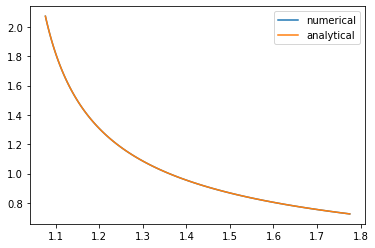

In [ ]:
plt.plot(sigma_ws_numerical, sigma_bs_numerical)
plt.plot(sigma_ws_analytical, sigma_bs_analytical)
plt.legend(["numerical", "analytical"])

<class 'numpy.float64'>
5.000000000000001 3.998262087802855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([1.10225833, 0.89837174])

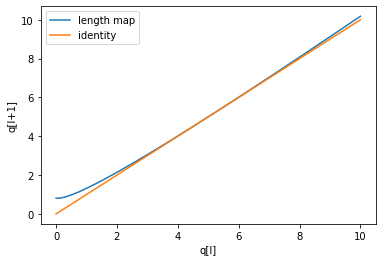

In [ ]:
get_sw_sb_from_q_star_analytical(5, tau=tau, check=True, max_qstar=10)

# Combining all analysis

<class 'numpy.ndarray'>


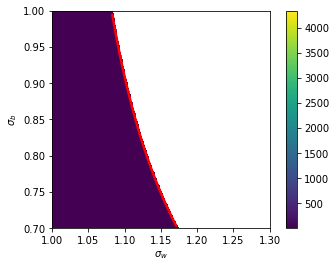

In [ ]:
nx, ny = (300,300)
x = np.linspace(1.0, 1.3, nx)
y = np.linspace(0.7, 1.0, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
zss = compute_q_star(xv, yv, tau=0.5, max_steps=500, clip=5000, err_val=float("nan"))
qstar_eval = np.logspace(.32, .86, 1000)
sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval)
sigma_ws_analytical = sigma_ws_bs_analytical[0]
sigma_bs_analytical = sigma_ws_bs_analytical[1]

plt.pcolormesh(x, y, zss)
plt.plot(sigma_ws_analytical, sigma_bs_analytical, color="red", linewidth=2.5)
plt.axis('scaled')
plt.xlabel("$\sigma_w$")
plt.ylabel("$\sigma_b$")
plt.colorbar()

# fig.subplots_adjust(right=1.2)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(im, cax=cbar_ax)
plt.show()

## Let's try running through the analysis for multiple $\tau$.

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


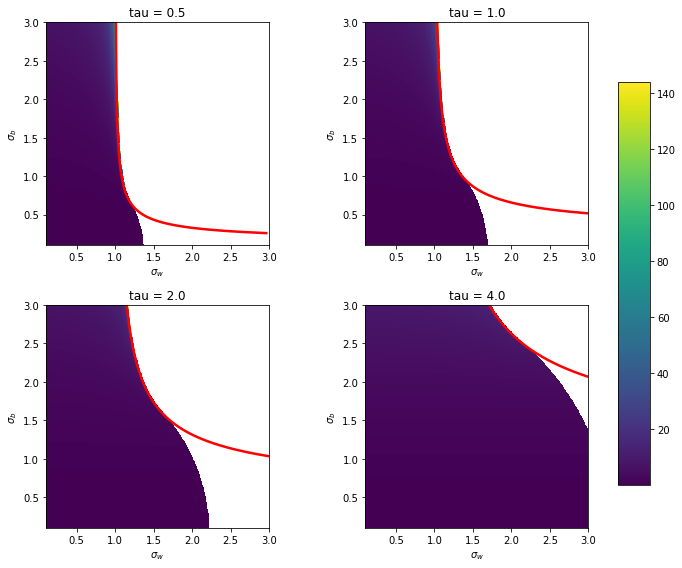

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
taus = np.array([[0.5, 1], [2,4]])
nx, ny = (400,300)
x = np.linspace(.1, 3, nx)
y = np.linspace(.1, 3, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
qstar_eval = np.logspace(-1, 4, 1000)

for i, j in [(0,0), (0,1), (1,0), (1,1)]:
  zss = compute_q_star(xv, yv, tau=taus[i][j], max_steps=100, clip=200, err_val=float("nan"))
  sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval, tau=taus[i][j])
  sigma_ws_analytical = sigma_ws_bs_analytical[0]
  sigma_bs_analytical = sigma_ws_bs_analytical[1]
  im = ax[i][j].pcolormesh(x,y,zss)
  # fig.colorbar(im, ax=ax, shrink=0.9)
  ax[i][j].plot(sigma_ws_analytical, sigma_bs_analytical, color="red", linewidth=2.5)
  ax[i][j].axis('scaled')
  ax[i][j].set_xlim([0.1, 3])
  ax[i][j].set_ylim([0.1, 3])
  ax[i][j].set_xlabel("$\sigma_w$")
  ax[i][j].set_ylabel("$\sigma_b$")
  ax[i][j].set_title(f"tau = {taus[i][j]}")

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout()
plt.show()  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


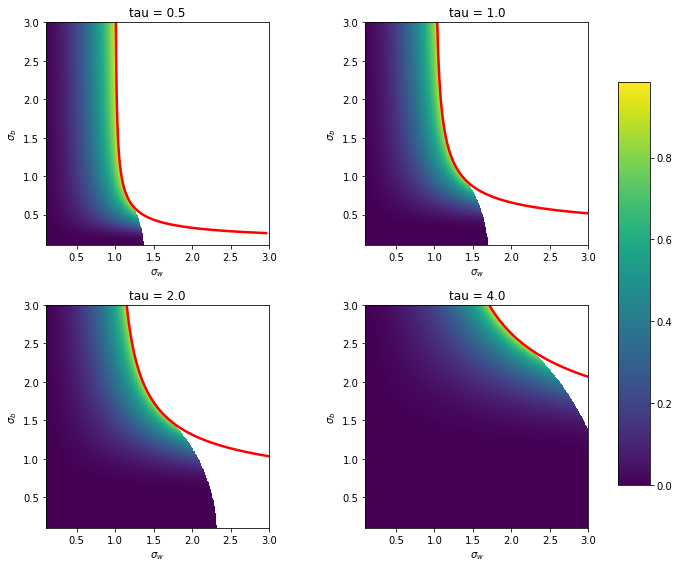

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
taus = np.array([[0.5, 1], [2,4]])
nx, ny = (400,300)
x = np.linspace(.1, 3, nx)
y = np.linspace(.1, 3, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
qstar_eval = np.logspace(-1, 4, 1000)

for i, j in [(0,0), (0,1), (1,0), (1,1)]:
  zss = compute_q_star(xv, yv, tau=taus[i][j], max_steps=1000, clip=4000, err_val=float("nan"))
  chi1 = 2 * xv**2 * norm.sf(taus[i][j]/np.sqrt(zss))
  sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval, tau=taus[i][j])
  sigma_ws_analytical = sigma_ws_bs_analytical[0]
  sigma_bs_analytical = sigma_ws_bs_analytical[1]
  im = ax[i][j].pcolormesh(x,y,chi1)
  # fig.colorbar(im, ax=ax, shrink=0.9)
  ax[i][j].plot(sigma_ws_analytical, sigma_bs_analytical, color="red", linewidth=2.5)
  ax[i][j].axis('scaled')
  ax[i][j].set_xlim([0.1, 3])
  ax[i][j].set_ylim([0.1, 3])
  ax[i][j].set_xlabel("$\sigma_w$")
  ax[i][j].set_ylabel("$\sigma_b$")
  ax[i][j].set_title(f"tau = {taus[i][j]}")

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout()
plt.show()  

# Part 3. Does the length map converges if initialised along the edge of chaos curve?

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


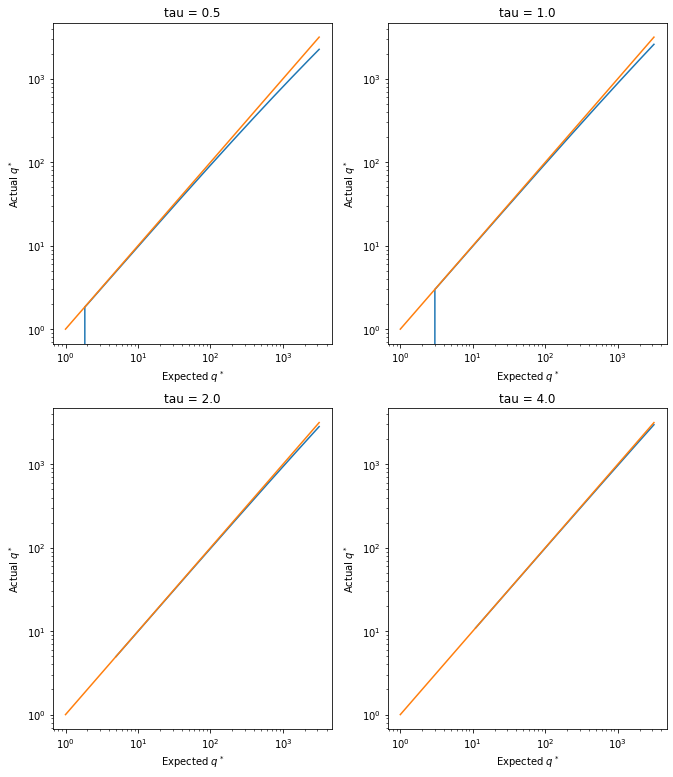

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
qstar_eval = np.logspace(0, 3.5, 500)
taus = np.array([[0.5, 1], [2,4]])

for i, j in [(0,0), (0,1), (1,0), (1,1)]:
  sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval, tau=taus[i][j])
  sigma_ws_analytical = sigma_ws_bs_analytical[0]
  sigma_bs_analytical = sigma_ws_bs_analytical[1]
  z = compute_q_star(sigma_ws_analytical, sigma_bs_analytical, tau=taus[i][j], max_steps=1000, clip=10000, err_val=-100)
  ax[i][j].plot(qstar_eval, z)
  ax[i][j].plot(qstar_eval, qstar_eval)
  ax[i][j].set_xscale("log")
  ax[i][j].set_yscale("log")
  ax[i][j].set_xlabel(r"Expected $q^*$")
  ax[i][j].set_ylabel(r"Actual $q^*$")
  ax[i][j].set_title(f"tau = {taus[i][j]}")

Practical simulations suggested yes, but convergence seems to be rather slow.

# Part 4. Computing the correlation map along the edge of chaos curve

The formula is 
$$R(\rho; q_{11}, q_{12}) = \sigma^2_w \int_\mathbb{R} \int_\mathbb{R} \phi(u_1(z_1, z_2)) \phi(u_2(z_1, z_2)) \, \gamma(dz_1) \gamma(dz_2) + \sigma^2_b.$$
where 
$$u_1(z_1, z_2) = \sqrt{q_{11}} z_1, \quad u_2(z_1, z_2) = \sqrt{q_{22}} \left[ \rho z_1 + \sqrt{1-\rho^2} z_2 \right].$$

In [ ]:
def correlation_map(prev, q11, q22=None, activation_func=None, sigma_b=None, sigma_w=None, q_conv=False, err_tol=1e-3, *args, **kwargs):
  if q22 == None:
    q22=q11
  
  if activation_func == None:
    def activation_func(x,tau=tau): 
      return soft_thresholding_numpy(x, tau=tau)
  
  if sigma_b == None or sigma_w == None:
    sw_sb = get_sw_sb_from_q_star_analytical(qstar, tau=tau)
    sigma_w = sw_sb[0]
    sigma_b = sw_sb[1]

  def u1(q11, z1):
    return( np.sqrt( q11 ) * z1 )

  def u2(prev, q22, z1, z2):
    res = np.sqrt( q22 ) * ( prev * z1 + np.sqrt( 1 - prev ** 2 ) * z2 )
    return( res )

  def integrator( z1, z2 ):
    inner = activation_func( u1( q11, z1 ), tau ) * activation_func( u2( prev, q22, z1, z2 ), tau )
    integrand = inner * np.exp( - ( z1 ** 2 + z2 **2 ) / 2 )
    return( integrand )

  z1_range = np.inf
  z2_range = np.inf
  integral = scipy.integrate.dblquad( integrator, -z1_range, z1_range, -z2_range, z2_range )[ 0 ] / (2*np.pi)
  res = (sigma_w ** 2) * integral + (sigma_b ** 2)

  new_q11 = length_map_analytical(q11, sw=sigma_w, sb=sigma_b, tau=tau)
  new_q22 = length_map_analytical(q22, sw=sigma_w, sb=sigma_b, tau=tau)

  if q_conv == True and (abs(new_q11 - q11) > err_tol or abs(new_q22 - q22) > err_tol):
    warnings.warn("length map does not converge, so the result may not be valid.")
    print(q11, new_q11)

  return( res/np.sqrt(new_q11 * new_q22) )

In [ ]:
correlation_map(0.9, .3, q_conv=True)

0.3 2.292403750816179


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: length map does not converge, so the result may not be valid.


0.9958038016438197

In [ ]:
get_sw_sb_from_q_star_analytical(10)

array([1.06943183, 1.0839329 ])

In [ ]:
rho_eval = np.linspace(0,1,30)
corr_outputs = [[], [], [], []]
q_eval = [.5, 1, 2, 4]

for i in range(4):
  print(q_eval[i])
  for rho in tqdm(rho_eval):
    corr = correlation_map(rho, q_eval[i])
    corr_outputs[i].append(corr)

0.5


100%|██████████| 30/30 [03:11<00:00,  6.37s/it]


1


 23%|██▎       | 7/30 [00:33<02:10,  5.69s/it]/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)
100%|██████████| 30/30 [03:25<00:00,  6.85s/it]


2


100%|██████████| 30/30 [03:42<00:00,  7.42s/it]


4


 37%|███▋      | 11/30 [01:16<02:37,  8.28s/it]

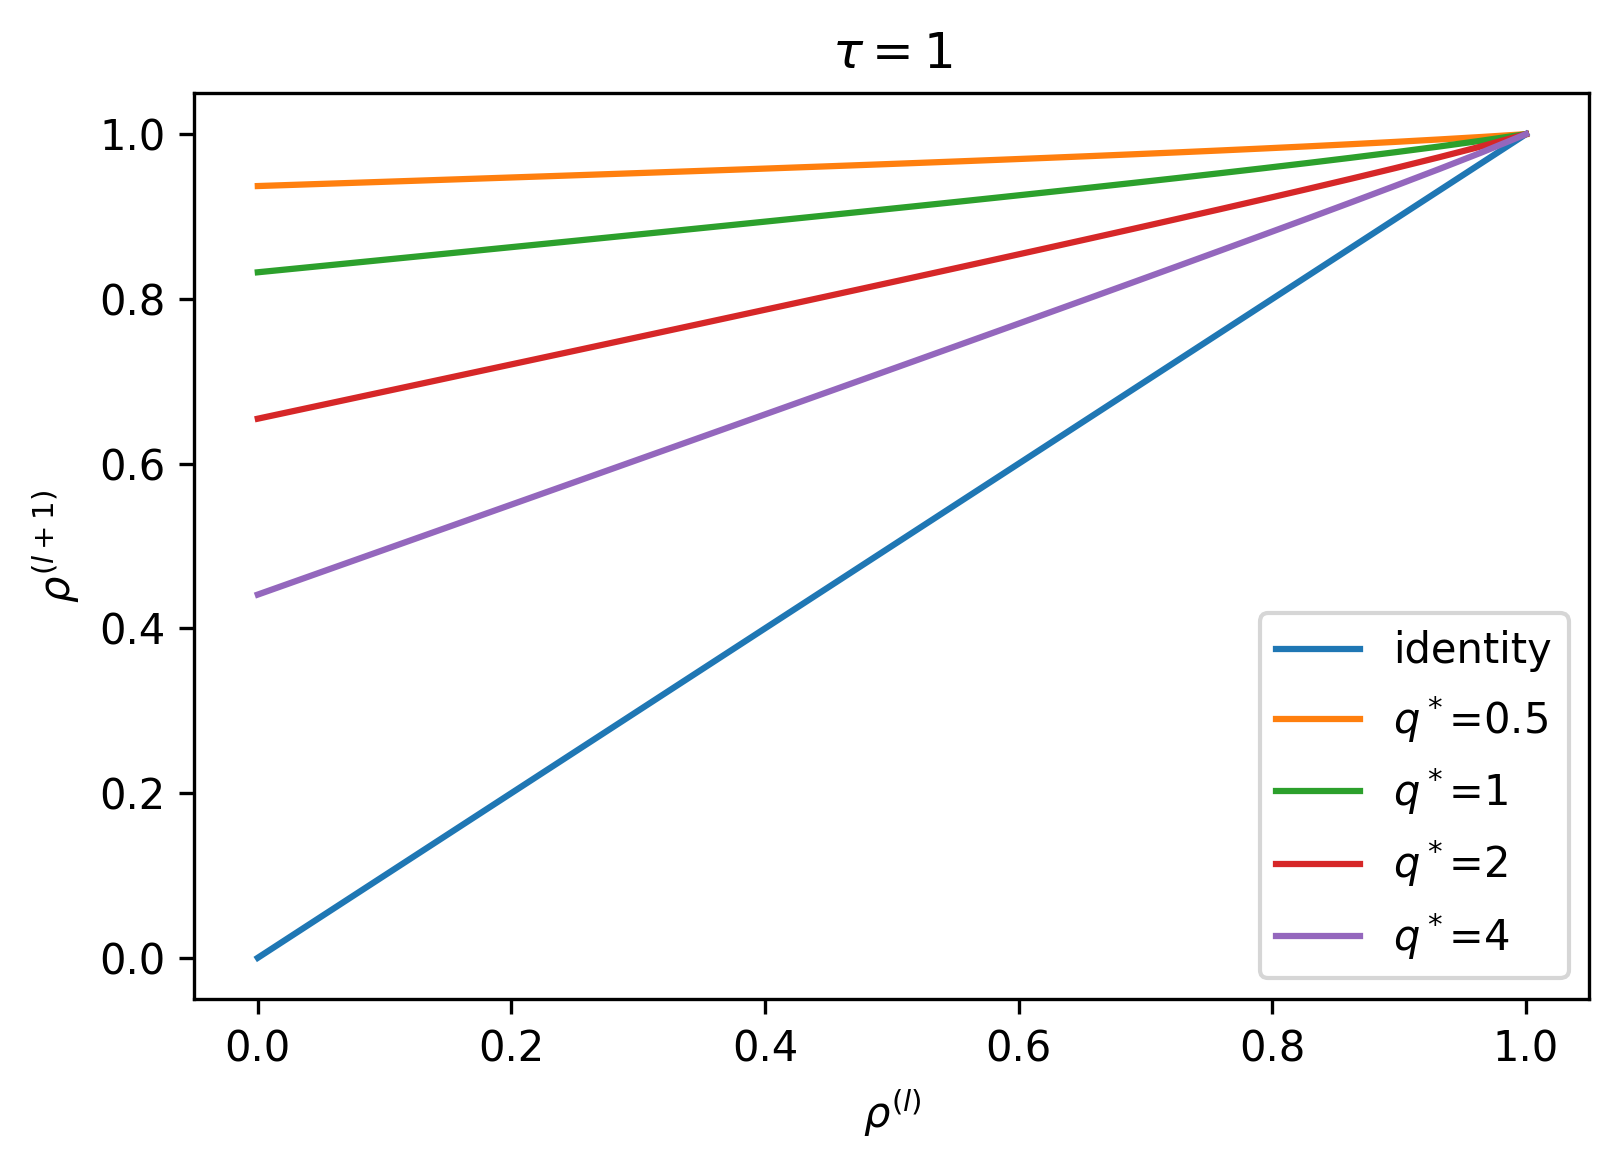

In [ ]:
fig, ax = plt.subplots()
fig.set_dpi(300)

ax.plot(rho_eval, rho_eval, label="identity")

for i in range(4):
  ax.plot(rho_eval, np.array(corr_outputs[i]), label=f"$q^*$={q_eval[i]}")

ax.set_xlabel(r"$\rho^{(l)}$")
ax.set_ylabel(r"$\rho^{(l+1)}$")
ax.set_title(r"$\tau = 1$")
ax.legend()